![Credit card being held in hand](credit_card.jpg)

Commercial banks receive _a lot_ of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this workbook, you will build an automatic credit card approval predictor using machine learning techniques, just like real banks do.

### The Data

The data is a small subset of the Credit Card Approval dataset from the UCI Machine Learning Repository showing the credit card applications a bank receives. This dataset has been loaded as a `pandas` DataFrame called `cc_apps`. The last column in the dataset is the target value.

In [1]:
def jupiter_print(str:str):
    """Print with upper and lower boundries."""
    print(f"{'*'*60}\n{str}\n{'*'*60}")

In [2]:
# Libs
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
cc_apps = pd.read_csv("cc_approvals.data", header=None) 
jupiter_print(f'Shape of the data: {cc_apps.shape}')
cc_apps.head()

************************************************************
Shape of the data: (690, 14)
************************************************************


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,g,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,g,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,g,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,g,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,s,0,+


In [3]:
# preprocessing
cc_apps_cor = cc_apps.copy()
jupiter_print(f"the types of columns:\n{cc_apps_cor.dtypes}")

# column [1] seems numerical
mask = ~cc_apps_cor[1].astype(str).str.fullmatch(r"\d+.\d+")
jupiter_print(f"non numeric values in column 1:\n {cc_apps_cor.loc[mask, 1].unique()}")

# replacing ? with nan in column 1
cc_apps_cor[1] = pd.to_numeric(cc_apps_cor[1], errors="coerce")

# checking the unique values in categorical columns
cols = cc_apps_cor.select_dtypes('object').columns
uniqs = {c: sorted(cc_apps_cor[c].dropna().unique()) for c in cols}
for key, val in uniqs.items():
    print(f"{key}:{val}\n")
cc_apps_cor[cols] = cc_apps_cor[cols].replace('?', np.nan)
    
# checking na in the DataFrame
jupiter_print(f"the nan values in different columns: \n{cc_apps_cor.isna().sum()}")

# recoding the target column
target_col_dic = {'+':1, '-':0}
cc_apps_cor[13] = cc_apps_cor.iloc[:,-1].map(target_col_dic).astype("Int64")

# checking rows with nan
jupiter_print(f"total number of rows with missing values: {cc_apps_cor.isna().any(axis=1).sum()}")
# cc_apps_cor = cc_apps_cor.dropna(axis=0)
# jupiter_print(f"shape of the DataFrame after nan elimination: {cc_apps_cor.shape}")

************************************************************
the types of columns:
0      object
1      object
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12      int64
13     object
dtype: object
************************************************************
************************************************************
non numeric values in column 1:
 ['?']
************************************************************
0:['?', 'a', 'b']

3:['?', 'l', 'u', 'y']

4:['?', 'g', 'gg', 'p']

5:['?', 'aa', 'c', 'cc', 'd', 'e', 'ff', 'i', 'j', 'k', 'm', 'q', 'r', 'w', 'x']

6:['?', 'bb', 'dd', 'ff', 'h', 'j', 'n', 'o', 'v', 'z']

8:['f', 't']

9:['f', 't']

11:['g', 'p', 's']

13:['+', '-']

************************************************************
the nan values in different columns: 
0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0

In [4]:
# scoring function
# Libs
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def scoring_fun(model, X_test, y_test, model_name:str, scoring:str = 'f1'):
    
    """Prints the different scores for the model, and checks the fit."""
    
    y_pred  = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    confusion_mtx = confusion_matrix(y_test, y_pred)
    
    # 1. Scores for test data
    print(f"The results of the {model_name} model:\n")
    print(f"accuracy:{accuracy}\n")
    print(f"precision:{precision}\n")
    print(f"recall:{recall}\n")
    print(f"f1:{f1 }\n")
    print(f"confusion_mtx:\n{confusion_mtx}\n")
    
    # 2. CV score
    print(f"Best CV Score: {model.best_score_:.4f}\n")
    
    # 3. checking fit (only for specific scorings[f1, accuracy])
    compare = False
    is_overfitting = False
    if scoring == 'f1':
        gap = model.best_score_ - f1
        compare=True
    elif scoring == 'accuracy':
        gap = model.best_score_ - accuracy
        compare=True
    else:
        print('Warning: cannot check overfitting if the scoring is not f1 or accuracy!')
        
    if compare:
        print(f"CV vs Test Gap: {gap:.4f}")
        if gap > 0.1:
            print('*'*60)
            print("Warning: Possible overfitting!")
            print('*'*60)
            is_overfitting = True
        elif gap < -0.05:
            print('*'*60)
            print("Warning: Test score higher than CV - check for data leakage!")
            print('*'*60)
            
    return accuracy, precision, recall, f1, confusion_mtx, is_overfitting

In [5]:
# visualizer function
# Libs
from sklearn.model_selection import learning_curve
from sklearn.metrics import ConfusionMatrixDisplay

def learning_curve_automated(base_estimator, model_results, model_name:str):
    """Visualize the fitting curve of the input model and its confusion matrix."""

    # Optimized parameters
    kf_lc = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state_)
    
    train_sizes, train_scores, val_scores = learning_curve(
        base_estimator, 
        X_train, 
        y_train, 
        cv=kf_lc, 
        scoring='roc_auc',
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5)
    )
    
    plt.figure(figsize=(5, 3))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Train Score')
    plt.plot(train_sizes, val_scores.mean(axis=1), label='CV Score')
    plt.xlabel('Training Size')
    plt.ylabel('ROC AUC')
    plt.title(f'Learning Curve -- {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

    # visualizing the confusion matrix for the best model
    disp = ConfusionMatrixDisplay(confusion_matrix=model_results[4],
                                  display_labels=base_estimator.classes_)
    disp.plot()
    plt.show()

In [6]:
# setting up the train-test datasets and preprocessing pipeline
# Libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# setting random_state for the code and scoring
random_state_ = 123
which_scoring='f1'

# using preprocessed data to form X and y
X = cc_apps_cor.drop(13, axis=1)
y = cc_apps_cor[13]

# seprating test and train sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=.2, 
    stratify=y, 
    random_state=random_state_
)

# making preprocessing part of the pipeline
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
nominal_categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), 
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first')) 
])

# Combine all transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('nom_cat', categorical_transformer, nominal_categorical_features)
    ],
    remainder='passthrough' 
)

# making KFold object for all grids
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state_)

In [7]:
# for supressing warnings related to imbalanced categories
import warnings
import os
warnings.filterwarnings('ignore')
os.environ['PYTHONWARNINGS'] = 'ignore'

The results of the LogisticRegression model:

accuracy:0.8333333333333334

precision:0.8166666666666667

recall:0.8032786885245902

f1:0.8099173553719008

confusion_mtx:
[[66 11]
 [12 49]]

Best CV Score: 0.8604

CV vs Test Gap: 0.0505


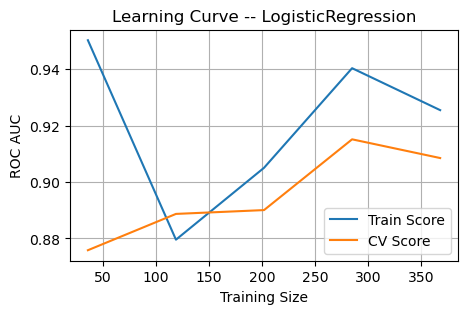

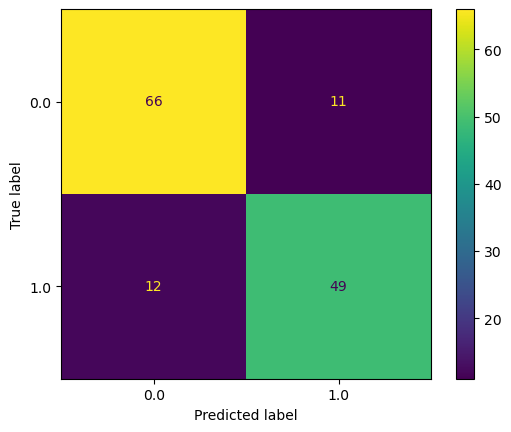

In [8]:
# Logistic regression model
# Libs
from sklearn.linear_model import LogisticRegression

# Setting up and fitting a Logistic regression model
pipe_lr = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=random_state_)),
    ('lr', LogisticRegression())
])

params = {
    'lr__C': np.logspace(-4, 4, 40),
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['saga'],
    'lr__class_weight': ['balanced'],
    'lr__random_state':[random_state_],
    'lr__max_iter': [5000]
}

grid_lr = RandomizedSearchCV(
    pipe_lr, 
    params, 
    cv=kf, 
    scoring=which_scoring,  
    n_jobs=-1,
    refit=True,
    return_train_score=True,
    n_iter=100
)

grid_lr = grid_lr.fit(X_train, y_train)

lr_results = scoring_fun(grid_lr, X_test, y_test, 'LogisticRegression', scoring=which_scoring)
learning_curve_automated(grid_lr, model_results=lr_results, model_name='LogisticRegression')

The results of the SVC model:

accuracy:0.8478260869565217

precision:0.803030303030303

recall:0.8688524590163934

f1:0.8346456692913385

confusion_mtx:
[[64 13]
 [ 8 53]]

Best CV Score: 0.8559

CV vs Test Gap: 0.0213


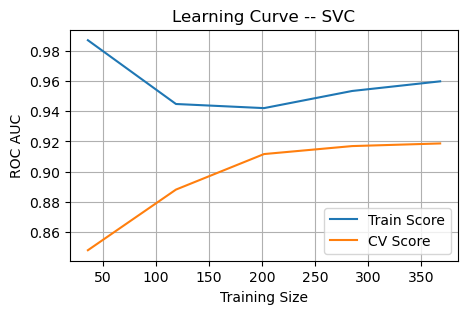

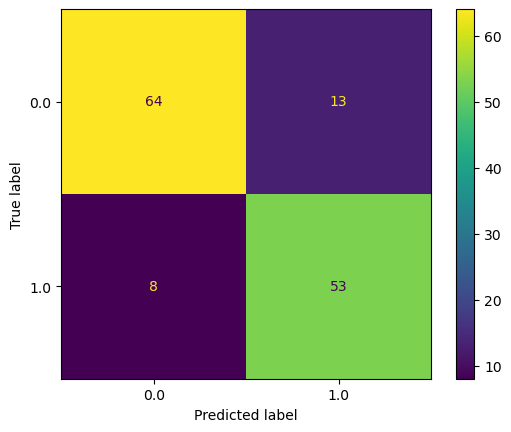

In [9]:
# Single Vector Classifier (SVC) model
# Libs
from sklearn.svm import SVC

# Setting up and fitting a Logistic regression model
pipe_svc = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=random_state_)),
    ('svc', SVC(probability=True, cache_size=1000))
])

params = {
    "svc__C": [0.01, 0.1, 1, 10, 100, 1000],
    "svc__gamma": ["scale", "auto", 1e-4, 1e-3, 1e-2, 1e-1, 1],
    "svc__degree": [2, 3, 4],
    "svc__random_state": [random_state_],
    "svc__kernel": ['rbf'],
    "svc__class_weight": ['balanced']
}

# Enhanced GridSearchCV with better settings
grid_svc = GridSearchCV(
    pipe_svc, 
    params, 
    cv=kf, 
    scoring=which_scoring,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_svc.fit(X_train, y_train)

# Fixed model name in results
svc_results = scoring_fun(grid_svc, X_test, y_test, 'SVC', scoring=which_scoring)
learning_curve_automated(grid_svc, model_results=svc_results, model_name='SVC')

The results of the KNeighborsClassifier model:

accuracy:0.8333333333333334

precision:0.8392857142857143

recall:0.7704918032786885

f1:0.8034188034188035

confusion_mtx:
[[68  9]
 [14 47]]

Best CV Score: 0.8227

CV vs Test Gap: 0.0193


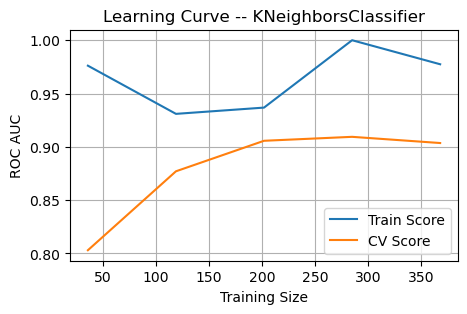

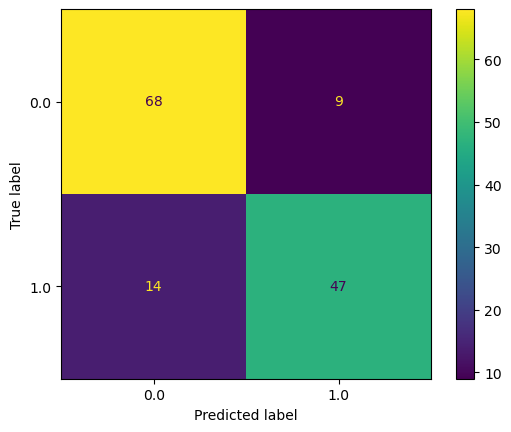

In [10]:
# Single Vector Classifier (SVC) model
# Libs
from sklearn.neighbors import KNeighborsClassifier

# Setting up and fitting a Logistic regression model
pipe_KNN = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=random_state_)),
    ('knn', KNeighborsClassifier())
])

params = {
    'knn__n_neighbors' : np.arange(1,31,2),
    'knn__weights' : ['uniform', 'distance'],
    'knn__metric' : ['minkowski'],
    'knn__p': [1, 2],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree'],
}

grid_knn = GridSearchCV(
    pipe_KNN, 
    params, 
    cv=kf, 
    scoring=which_scoring,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

grid_knn = grid_knn.fit(X_train, y_train)

knn_results = scoring_fun(grid_knn, X_test, y_test, 'KNeighborsClassifier', scoring=which_scoring)
learning_curve_automated(grid_knn, model_results=knn_results, model_name='KNeighborsClassifier')

In [11]:
# best model selection
models = {
    'SVC': (grid_svc, svc_results),
    'LogisticRegression': (grid_lr, lr_results),
    'KNeighborsClassifier': (grid_knn, knn_results)
}

best_model_name = None
best_score = -float('inf')  # Better initialization

for model_name, (grid_obj, results) in models.items():
    accuracy, precision, recall, f1, conf_matrix, is_overfitting = results
    
    if which_scoring == 'f1':
        score=f1
    elif which_scoring == 'accuracy':
        score=accuracy
        
    # Select best non-overfitting model
    if score > best_score and not is_overfitting:
        print(grid_obj.best_score_)
        best_model_name = model_name
        best_score = grid_obj.best_score_

if best_model_name:
    grid_best, results_best = models[best_model_name]
    
    print(f"The best model: {best_model_name}\n")
    print(f"CV score: {grid_best.best_score_:.4f}\n")
    print(f"Best params:")
    for key, val in grid_best.best_params_.items():
        print(f"{key}: {val}")
    print(f"\nTest Set Performance:")
    print(f"  Accuracy:  {results_best[0]:.4f}")
    print(f"  Precision: {results_best[1]:.4f}")
    print(f"  Recall:    {results_best[2]:.4f}")
    print(f"  F1 Score:  {results_best[3]:.4f}")
else:
    print("No model met the selection criteria (due to overfitting)")

0.8559197547221965
The best model: SVC

CV score: 0.8559

Best params:
svc__C: 0.1
svc__class_weight: balanced
svc__degree: 2
svc__gamma: scale
svc__kernel: rbf
svc__random_state: 123

Test Set Performance:
  Accuracy:  0.8478
  Precision: 0.8030
  Recall:    0.8689
  F1 Score:  0.8346
